# Physics-Informed Gaussian Process solution of a nonlinear elliptic PDE

ECEN 689 Scientific Machine Learning - Spring 2022

Python (Numpy and Scipy) implementation of PIGP solution of a prototypical nonlinear PDE.

Author: Ming Zhong <br>
Texas A&M Institute of Data Science<br>
Texas A&M University<br>

This code demonstrates training a physically-informed Gaussian Process (PIGP) to solve the following nonlinear elliptic PDE problem:
  \begin{aligned}
  &\Delta u(x, y) + \tau(u)(x, y) = f(x, y)\,, \quad (x, y) \in [0,1] \times [0,1]\,,\\
    & u(x, y) = g(x, y), \quad (x, y) \in \partial [0, 1]^2
  \end{aligned}
  Here $\Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$. In this experiment, we set 
  $$
  u_{true}(x,y) = \sin(\pi x)\sin(\pi y) + 4\sin(4\pi x)\sin(4\pi y),
  $$
one can set $f(x,y)$ and $g(x,y)$ to obtain this solution by plugging $u_{true}(x,y)$ in the PDE and boundary condition.

In [ ]:
# the main driver for testing KDEP solver
import numpy as np
import scipy as sp
from scipy import sparse
!pip -q install pyDOE
from pyDOE import lhs  # for latin hypercube sampling
import time

# define the true solution
def Nonlinear_Elliptic_true(x1s, x2s):
    X1, X2 = np.meshgrid(x1s, x2s)
    # be careful about meshgrid
    # X1 = [[X11, \cdots, X1N]] (row-vector) repeat M times
    # X2 = [[X21], \cdots, [X2M]] (column-vector) repeat N times
    # use the order = 'F' so that it goes column first
    X1 = X1.flatten()[:, None]
    X2 = X2.flatten()[:, None]
    return np.sin(np.pi * X1) * np.sin(np.pi * X2) \
            + 4.0 * np.sin(4.0 * np.pi * X1) * np.sin(4.0 * np.pi * X2)
# define the right hand forcing
def Nonlinear_Elliptic_RHS(x1, x2):    
    u1 = np.sin(np.pi * x1) * np.sin(np.pi * x2)
    u2 = 4.0 * np.sin(4.0 * np.pi * x1) * np.sin(4.0 * np.pi * x2)
    return 2.0 * np.pi**2.0 * u1 + 2.0 * (4.0 * np.pi)**2.0 * u2 + np.power(u1 + u2, 3.0)

In [ ]:
# set up the fine mesh for plotting and computing errors later
x1s = np.linspace(0.0, 1.0, 101)
x2s = np.linspace(0.0, 1.0, 101)
u = Nonlinear_Elliptic_true(x1s, x2s)
X1, X2 = np.meshgrid(x1s, x2s)

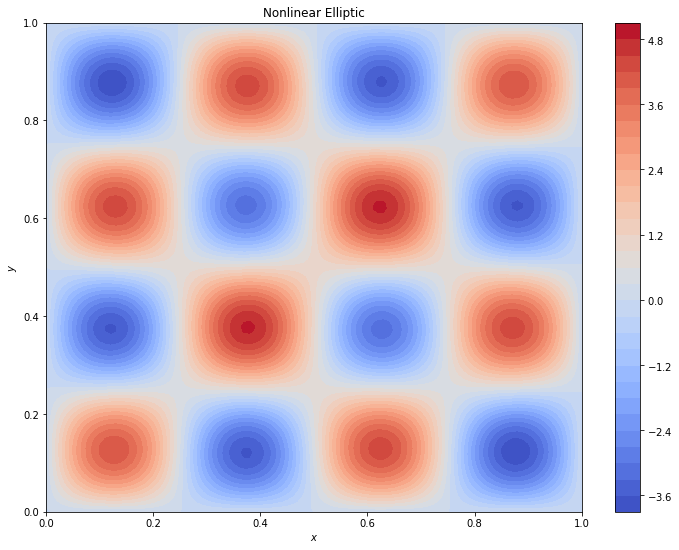

In [ ]:
# plot the true solution
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
fig = plt.figure(figsize = (12, 9))
ax = fig.add_subplot(1, 1, 1)
cPlot = ax.contourf(X1, X2, np.reshape(u, X1.shape), 30, cmap = plt.cm.coolwarm)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Nonlinear Elliptic')
fig.colorbar(cPlot, format = fmt)
plt.show()

In [ ]:
# set up the test parameters
name = 'Nonelinear_Elliptic'
d = 2
D = 1
x1lo = 0.0
x1hi = 1.0
x2lo = 0.0
x2hi = 1.0
domain = np.array([[x1lo, x1hi], [x2lo, x2hi]])
# points inside Omega
M_omega = 900
# points on the boundary
M_BC = 124
# total number of points
M = M_omega + M_BC
# set up the boundary points
MBC_each = int(M_BC/4)
# set up the left boundary: x1 = 0, x2 \in (0, 1)
x2LBC = np.linspace(x2lo, x2hi, MBC_each + 2)[1:-1][:, None]
x1LBC = x1lo * np.ones_like(x2LBC)
# set up the right boundary: x1 = 1, x2 \in (0, 1)
x2RBC = np.linspace(x2lo, x2hi, MBC_each + 2)[1:-1][:, None]
x1RBC = x1hi * np.ones_like(x2RBC)
# set up the south boundary: x1 \in (0, 1), x2 = 0
x1SBC = np.linspace(x1lo, x1hi, MBC_each + 2)[1:-1][:, None]
x2SBC = x2lo * np.ones_like(x1SBC)
# set up the right boundary: x1 = 1, x2 \in [0, 1]
x1NBC = np.linspace(x1lo, x1hi, MBC_each + 2)[1:-1][:, None]
x2NBC = x2hi * np.ones_like(x1NBC)
# put them together
X_BC = np.hstack((np.concatenate((x1LBC, x1RBC, x1SBC, x1NBC)), np.concatenate((x2LBC, x2RBC, x2SBC, x2NBC))))
# g(x) for x \in \partial\Omega
yBC = np.zeros((X_BC.shape[0], 1))
# setup the collocation points (inside Omega)
# draw i.i.d samples from latin hyper cube
LHC_samples = lhs(d, samples = M_omega)
X_omega = np.zeros((M_omega, d))
for d_idx in range(d):
    X_omega[:, d_idx] = domain[d_idx, 0] + (domain[d_idx, 1] - domain[d_idx, 0]) * LHC_samples[:, d_idx]  \
# put them all together
yOmega = Nonlinear_Elliptic_RHS(X_omega[:, 0], X_omega[:, 1])[:, None]
yM = np.concatenate((yOmega, yBC))
xM = np.concatenate((X_omega, X_BC))

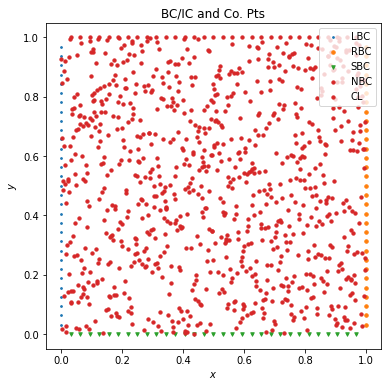

In [ ]:
# preset marker styles and colors
marker_size = 12
markers = ['.', 'o', 'v', '8', 's', 'p', 'P', '*', 'h', 'D']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# plot the data points (collocation points and BC points)
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x1LBC, x2LBC, s = marker_size, c = colors[0], marker = markers[0], label = 'LBC')
ax.scatter(x1RBC, x2RBC, s = marker_size, c = colors[1], marker = markers[1], label = 'RBC')
ax.scatter(x1SBC, x2SBC, s = marker_size, c = colors[2], marker = markers[2], label = 'SBC')
ax.scatter(x1NBC, x2NBC, s = marker_size, c = colors[3], marker = markers[3], label = 'NBC')
ax.scatter(X_omega[:, 0], X_omega[:, 1], s = marker_size, c = colors[3], marker = markers[3], label = 'CL')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('BC and Co. Pts')
ax.legend(loc = 'upper right')
plt.show() 

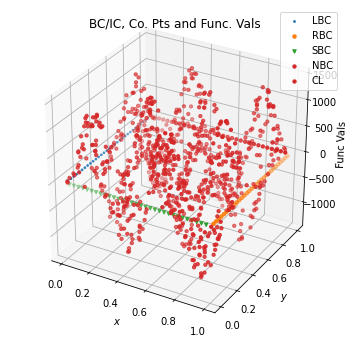

In [ ]:
# plot the boundary values on those points shown before
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
ax.scatter(x1LBC, x2LBC, np.zeros_like(x1LBC), s = marker_size, c = colors[0], marker = markers[0], label = 'LBC')
ax.scatter(x1RBC, x2RBC, np.zeros_like(x1RBC), s = marker_size, c = colors[1], marker = markers[1], label = 'RBC')
ax.scatter(x1SBC, x2SBC, np.zeros_like(x1SBC), s = marker_size, c = colors[2], marker = markers[2], label = 'SBC')
ax.scatter(x1NBC, x2NBC, np.zeros_like(x1NBC), s = marker_size, c = colors[3], marker = markers[3], label = 'NBC')
ax.scatter(X_omega[:, 0], X_omega[:, 1], yOmega, s = marker_size, c = colors[3], marker = markers[3], label = 'CL')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('Func Vals')
ax.set_title('BC/IC, Co. Pts and Func. Vals')
ax.legend(loc = 'upper right')
plt.show() 

In [ ]:
# define the kernel length scale (vector-form)
sigma = M**(-0.25) * np.ones(d)
# define the distance function
def sqdist(x, y, d_vec):
    # sqdist:          Mahalanobis Distance
    # x(i, :), y(j, :) \in R^d, and D \in R^{dxd}
    # sqdist(x, y, D): returns dist(i, j) = (x(i, :) - y(j, :)) * D * (x(i, :) - y(j, :))'
    # D is a diagnoal matrix, given by d_vec
    # x.shape = (Nx, dx) and y.shape = (Ny, dy), dx has to be the same as dy
    # The built-in scipy.spatial.distance.cdist(x, y, metric = 'euclidean') can be used
    # however it does not allow for sparse matrix
    # dist[np.diag_indices_from(dist)] = 0.0 if x and y are the same
    if ((x.ndim != 2) or (y.ndim != 2)):
        raise NameError('x and y must be a 2D tensor!!')           
    Nx, dx = x.shape
    Ny, dy = y.shape
    if ((dx != d) or (dy != d)):
        raise NameError('x and y must have the same dimension!!')
    # deal with the first exception
    if ((Nx == 0) or (Ny == 0)):
        dist = np.zeros((Nx, Ny))
    else:
        D = sp.sparse.spdiags(d_vec, 0, d, d)
        x_normsq = np.sum(x * (x@D), axis = -1)
        y_normsq = np.sum(y * (y@D), axis = -1)
        x_normsq = np.expand_dims(x_normsq, axis = -1) # column
        y_normsq = np.expand_dims(y_normsq, axis = 0)  # row   
        # when it is close to 0, it might become negative (numerical error)
        dist = np.absolute(x_normsq - 2.0 * x@((y@D).T) + y_normsq)
    return dist 

# K for Gaussian kernel
def exponential_kernel(x, y):
    return np.exp(-sqdist(x, y, 1.0/(2.0 * sigma**2.0)))

# dK_dyj for Gaussian kernel
def exponential_kernel_dyj(x, y, j_dim):
    Kxy = exponential_kernel(x, y)        
    # since python defaults to a vector with 1D shape, i.e., of shape (Nx,)
    # we need to add the dimension back via expand_dims with the parameter axis
    # axis = -1, becomes column, axis = 0, becomes row
    xj = np.expand_dims(x[:, j_dim], axis = -1) # column
    yj = np.expand_dims(y[:, j_dim], axis = 0)  # row
    # column vector - row vector becomes a matrix of size Nc times Nr
    # where Nc is the number of entries in the column vector
    # where Nr is the number of entries in the row vector
    # no need to use np.matlib.repmat
    return Kxy * (xj - yj)/(sigma[j_dim]**2.0)  

# \Laplace_y(K) for Gaussian kernel
def exponential_kernel_Laplace_y(x, y):
    Kxy = exponential_kernel(x, y)
    return Kxy * (sqdist(x, y, 1.0/(sigma**4.0)) - np.sum(1.0/sigma**2.0))

# \Laplace_x(\Laplace_y(K)) = \sum_{i = 1}^dx\sum_{j = 1}^dy d^4K_dxi^2_dyj^2 for Gaussian kernel
def exponential_kernel_Laplace_x_Laplace_y(x, y):
    Kxy = exponential_kernel(x, y) 
    return Kxy * ((sqdist(x, y, 1.0/(sigma**4.0)) - np.sum(1.0/(sigma**2.0)))**2.0 \
           - 4.0 * sqdist(x, y, 1.0/(sigma**6.0)) + 2.0 * np.sum(1.0/(sigma**4.0)))

In [ ]:
# the linear operators associated to the non-linear Elliptic PDE
# L_1(u) = u, L_2(u) = \Laplace(u)
# in Python indexing 1 -> 0, and 2 -> 1
# here x_vec = (x, y)
# only L_1 is on the boundary
# define the operator K(phi, phi)(x)
# should be of size 2x2, but since it is symmetric, we only save
# the upper triangular part, ending up with 2 + 1, 1 = 2 \choose 2.
Kphiphi = [];
# (L_1, L_1), (L_1, L_2)
Kphiphi.append(lambda x, y: exponential_kernel(x, y))
Kphiphi.append(lambda x, y: exponential_kernel_Laplace_y(x, y))
# (L_2, L_2)
Kphiphi.append(lambda x, y: exponential_kernel_Laplace_x_Laplace_y(x, y))
# for K(x, phi)
Kxphi = Kphiphi[0 : 2]
# Nonlienar Elliptic PDE: -\Laplace(u) + u^3 = f
tau = lambda z: np.power(z, 3.0)
dtau = lambda z: 3.0 * np.power(z, 2.0)
# z_1 = u, z_2 = \Laplace(u)
thePDE = lambda z: -z[:, 1] + tau(z[:, 0])
# gradients of the PDE
PDEgrad = []
PDEgrad.append(lambda z: dtau(z[:, 0]))
PDEgrad.append(lambda z: -np.ones_like(z[:, 1]))
# BC for Helmholtz: u(x) = g(x)
theBC = lambda z: z[:, 0]
BCgrad = [lambda z: np.ones_like(z[:, 0])]
# for regularization
# for the nugget term
eta = 1e-10
# for the penalty on the PDE constraint
beta = 1e-5
# for gradient descend
IG = lambda N: np.random.normal(loc = 0.0, scale = 1.0, size = (N, 1))
tol = 1e-12
num_iters = 15

In [ ]:
# size for Theta
N = M  + M_omega
# assemble the theta matrix
theta = np.zeros((N, N))
# first block: L_1L_1 * K(x, x), M-by-M
rIdx = np.arange(0, M)
cIdx = np.arange(0, M)
theta[np.ix_(rIdx, cIdx)] = Kphiphi[0](xM, xM)
# second block: L_1L_2 * K(x, x), M-by-M_omega
rIdx = np.arange(0, M)
cIdx = M + np.arange(0, M_omega)
theta[np.ix_(rIdx, cIdx)] = Kphiphi[1](xM, xM[0:M_omega, :])
# third block: L_2L_1 * K(x, x), M_omega-by-M, symmetric
rIdx = M + np.arange(0, M_omega)
cIdx = np.arange(0, M)                                                  
theta[np.ix_(rIdx, cIdx)] = theta[np.ix_(cIdx, rIdx)].T
# final block: L_2L_2 * K(x, x), M_omega-by-M_Omega
rIdx = M + np.arange(0, M_omega)
cIdx = M + np.arange(0, M_omega)
theta[np.ix_(rIdx, cIdx)] = Kphiphi[2](xM[0:M_omega, :], xM[0:M_omega, :])
# find the inverse of theta (after adding the nugget) via Cholesky
trace1 = theta[0 : M, 0 : M].trace()
idx = np.arange(0, M)
R_diag = np.zeros(N)
R_diag[idx] = 1.0
idx = M + np.arange(0, M_omega)
R_diag[idx] = theta[np.ix_(idx, idx)].trace()/trace1
theta[np.diag_indices_from(theta)] = theta[np.diag_indices_from(theta)] + eta * R_diag
L = np.linalg.cholesky(theta)
L_inv = np.linalg.inv(L)
theta_inv = L_inv.T@L_inv

In [ ]:
# define the PDE/BC constrain function F(z)
def the_RHS_F(z, M_omega, M_BC, thePDE, theBC):
    # z is a column vector (ndim = 2), slicing as if z is a just a vector (ndim = 1)
    # take out the data part
    # z = [z_1^T, z_2^T]
    # np.reshape does row first by default, use the order param to change it to 
    # behave like MATLAB, column-first
    M = M_omega + M_BC
    z1 = np.reshape(z[0 : M], (M, 1), order = 'F')
    z2 = np.reshape(z[M :], (M_omega, 1), order = 'F')
    z_omega = np.hstack((z1[0 : M_omega, :], z2))
    z_BC = z1[M_omega : M, :]
    F = np.zeros(M)
    F[0 : M_omega] = thePDE(z_omega)
    F[M_omega :] = theBC(z_BC)
    return np.reshape(F, (M, 1))
# define grad(F)(z), using sparse storage
def gradient_of_RHS(z, M_omega, M_BC, thePDE_grad, theBC_grad):
    # construct a COO matrix using scipy.sparse.coo_matrix using the format
    # A = coo_matrix((data, (i, j)), where 
    # A[i[k], j[k]] = data[k], so data, i, and j should be vectors of the same length
    # coo_matrix is not good for matrix/vector multiplication/operation
    # need to change it to CSC or CSR matrix later
    M = M_omega + M_BC
    N = M + M_omega 
    # take care of the possible situation when observation data is present
    z1 = np.reshape(z[0 : M], (M, 1), order = 'F')
    z2 = np.reshape(z[M :], (M_omega, 1), order = 'F')
    z_omega = np.hstack((z1[0 : M_omega, :], z2))
    z_BC = z1[M_omega : M, :]
    # prepare the sparse storage
    data_vec = np.zeros(N)
    row_idx = np.zeros(N)
    col_idx = np.zeros(N)
    # for z1
    row_idx[0 : M] = np.arange(0, M)
    col_idx[0 : M] = np.arange(0, M)
    data_vec[0 : M_omega] = thePDE_grad[0](z_omega)
    data_vec[M_omega : M] = theBC_grad[0](z_BC)  
    # for z2
    row_idx[M : ] = np.arange(0, M_omega)
    col_idx[M :] = M + np.arange(0, M_omega)
    data_vec[M : ] = thePDE_grad[1](z_omega)   
    # construct the sparse matrix
    gradF = sp.sparse.coo_matrix((data_vec, (row_idx, col_idx)), shape = (M, N))        
    # gradF = np.zeros((M, N))
    # gradF[row_idx.astype(np.int32), col_idx.astype(np.int32)] = data_vec
    return gradF

In [ ]:
# define the total loss
def kernel_total_loss(z, theta_inv, F, y, D):
    return z.T@(theta_inv@z) + np.linalg.norm(D@(F(z) - y), 2)**(2.0)
# define the gradient of the loss
def kernel_loss_gradient(z, theta_inv, F, gradF, y, D_sq):
    # gradF(z) is a coo_matrix
    # gradF(z) used in column operation, so change it to csc
    # gradF(z).T used in row operation, so change it to csr
    gradFz = gradF(z)
    gradFzT = (gradFz.T).tocsr()
    gradFz = gradFz.tocsc()
    # solve Ax = b use the built-int linear solve (or qr? lu? chol?)
    #print('The conditional number of A is: %10.4e' %(np.linalg.cond(A, 2)))
    A = -(theta_inv + gradFzT@(D_sq@gradFz))
    b = theta_inv@z + gradFzT@(D_sq@(F(z) - y))
    return np.linalg.solve(A, b)
# the Gauss-Newton descent for PIGP
def kernel_GNM_gd(z0, total_loss, loss_gradient, tol, num_iters):
    # step size is fixed at 1 for now
    alphal = 1.0
    zl = z0
    loss_hist = np.zeros(num_iters + 1)
    loss_hist[0] = total_loss(zl)
    print('Iter = %2d, Loss = %10.4e' %(0, loss_hist[0]))
    for idx in range(1, num_iters + 1):
        # might need to consider adaptive alphal
        zlp1 = zl + alphal * loss_gradient(zl)
        loss_hist[idx] = total_loss(zlp1)
        print('Iter = %2d, Loss = %10.4e' %(idx, loss_hist[idx]))
        if ((np.linalg.norm(zlp1 - zl, 2)/np.linalg.norm(zl, 2) < tol) or 
            (np.absolute(loss_hist[idx] - loss_hist[idx - 1])/loss_hist[idx - 1] < tol)):
            break
        else:
            zl = zlp1
    if (idx < num_iters):
        loss_hist = np.delete(loss_hist, np.arange(idx, num_iters + 1))
    return zlp1, loss_hist
# K(x, phi) used in u(x) and var(x)
def kernel_x_phi(x, xM, M_omega, M_BC, Kxphi):
    M = M_omega + M_BC
    N = M + M_omega
    ker_at_x = np.zeros((x.shape[0], N))
    # for z_1, M points
    cIdx = np.arange(0, M)
    ker_at_x[:, cIdx] = Kxphi[0](x, xM)
    # for z_1, M_omega points
    cIdx = M + np.arange(0, M_omega)
    ker_at_x[:, cIdx] = Kxphi[1](x, xM[0 : M_omega, :])
    return ker_at_x
# the solution u(x)
def get_sol_at_x(x, xM, M_omega, M_BC, Kxphi, theta_inv, z):
    return kernel_x_phi(x, xM, M_omega, M_BC, Kxphi)@(theta_inv@z)
# the variance var(x)
def get_var_at_x(x, xM, M_omega, M_BC, Kxphi, theta_inv):
    ker_at_x = kernel_x_phi(x, xM, M_omega, M_BC, Kxphi)
    return np.absolute(np.diagonal(Kxphi[0](x, x) - ker_at_x@(theta_inv@ker_at_x.T)))

In [ ]:
# solve the PIGP problem
start_time = time.time()
F = lambda z: the_RHS_F(z, M_omega, M_BC, thePDE, theBC)
gradF = lambda z: gradient_of_RHS(z, M_omega, M_BC, PDEgrad, BCgrad)
D_vec = beta**(-1.0) * np.ones(M)
D = sp.sparse.spdiags(D_vec, 0, M, M)
D_sq = sp.sparse.spdiags(D_vec**(2.0), 0, M, M)
total_loss = lambda z: kernel_total_loss(z, theta_inv, F, yM, D)
loss_gradient = lambda z: kernel_loss_gradient(z, theta_inv, F, gradF, yM, D_sq);
z, loss_hist = kernel_GNM_gd(IG(N), total_loss, loss_gradient, tol, num_iters)
# find u(x) and var(x)
u_kernel = lambda x: get_sol_at_x(x, xM, M_omega, M_BC, Kxphi, theta_inv, z)
u_var = lambda x: get_var_at_x(x, xM, M_omega, M_BC, Kxphi, theta_inv)  
print('It takes %0.2f secs to solve the PDE' %(time.time() - start_time))

Iter =  0, Loss = 3.7746e+18
Iter =  1, Loss = 5.0923e+15
Iter =  2, Loss = 3.3608e+11
Iter =  3, Loss = 7.4823e+04
Iter =  4, Loss = 9.6110e+03
Iter =  5, Loss = 9.6111e+03
It takes 1.38 secs to solve the PDE


In [ ]:
# compute the L2, L1 and Linfty errors
x1 = np.linspace(x1lo, x1hi, 101)
x2 = np.linspace(x2lo, x2hi, 101)
X1, X2 = np.meshgrid(x1, x2)
X = np.hstack((X1.flatten()[:, None], X2.flatten()[:, None]))
u_true = Nonlinear_Elliptic_true(x1, x2)
u_PIGP = u_kernel(X)
err_all = np.absolute(u_true - u_PIGP)
L1_err = np.sum(err_all)/np.sum(np.absolute(u_true))
L2_err = np.power(np.sum(np.power(err_all, 2.0)), 0.5)/np.power(np.sum(np.power(u_true, 2.0)), 0.5)
max_err = np.max(err_all)/np.max(np.absolute(u_true))
print('L_1     Err: %8.2e' %(L1_err))
print('L_2     Err: %8.2e' %(L2_err))
print('L_infty Err: %8.2e' %(max_err))

L_1     Err: 1.39e-04
L_2     Err: 1.34e-04
L_infty Err: 1.24e-04


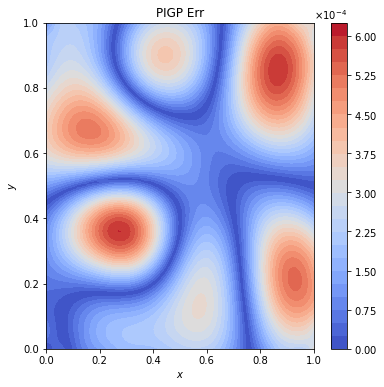

In [ ]:
# Plot the point wise erros
figsize = (12, 6)
num_cLines = 25
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(1, 1, 1)
err_contourf = ax.contourf(X1, X2, np.reshape(err_all, X1.shape), num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('PIGP Err')
fig.colorbar(err_contourf, format=fmt)
plt.show()

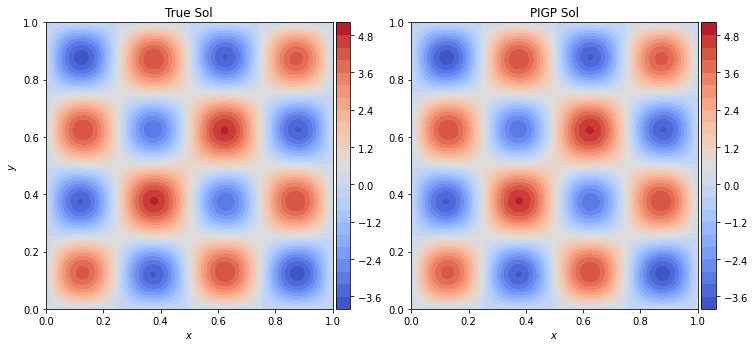

In [ ]:
# for shrinking the size of the colorbar accordingly
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize = figsize)
ax = fig.add_subplot(1, 2, 1)
true_contour = ax.contourf(X1, X2, np.reshape(u_true, X1.shape), num_cLines, cmap = plt.cm.coolwarm)
ax.set_aspect('equal', 'box')
ax.set(xlabel = '$x$', ylabel = '$y$', title = 'True Sol')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)        
fig.colorbar(true_contour, format = fmt, cax = cax)        
ax = fig.add_subplot(1, 2, 2)
GP_contour = ax.contourf(X1, X2, np.reshape(u_PIGP, X1.shape), num_cLines, cmap = plt.cm.coolwarm)
ax.set_aspect('equal', 'box')
ax.set(xlabel = '$x$', title = 'PIGP Sol')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)        
fig.colorbar(GP_contour, format = fmt, cax = cax)
plt.show() 

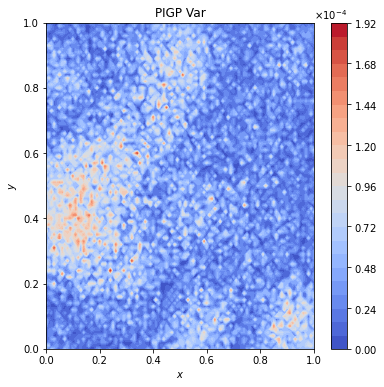

In [ ]:
# plot the variance
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(1, 1, 1)
var_contour = ax.contourf(X1, X2, np.reshape(u_var(X), X1.shape), num_cLines, cmap = plt.cm.coolwarm)
ax.set(xlabel = '$x$', ylabel = '$y$', title = 'PIGP Var')
fig.colorbar(var_contour, format = fmt)   
plt.show()  